<a href="https://colab.research.google.com/github/ghsagar/friend-recommendation-facebook/blob/main/facebook_friend_recommendation_ghimiresgar2015_gmail_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

In [ ]:
#reading graph
if not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('drive/My Drive/Facebook/data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('drive/My Drive/Facebook/data/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
  g=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [ ]:
print(pd.read_csv("/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv"))

               1   690569
0              1   315892
1              1   189226
2              2   834328
3              2  1615927
4              2  1194519
...          ...      ...
9437513  1862219  1187308
9437514  1862219   563943
9437515  1862219  1044046
9437516  1862219  1022613
9437517  1862220  1748794

[9437518 rows x 2 columns]


In [ ]:
%%time
###generating bad edges from given graph
import random
# present_edges=g.edges()
# missing_edges=set([])
# while len(missing_edges)<len(present_edges):

#   a=random.randint(1,1862220)
#   b=random.randint(1,1862220)
  

#   if (a,b) not in present_edges and a!=b:
#     try:
    
#       if nx.shortest_path_length(g,source=a,target=b)>2:
#         missing_edges.add((a,b))
#       continue
#     except:
#       missing_edges.add((a,b))

#   continue
# print(len(missing_edges))


if not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p'))
else:
    missing_edges = pickle.load(open('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p','rb'))

CPU times: user 2.15 s, sys: 1.3 s, total: 3.45 s
Wall time: 4.45 s


## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [ ]:
from sklearn.model_selection import train_test_split

df_pos = pd.read_csv('/content/drive/My Drive/Facebook/data/train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
y_positive=np.ones(len(df_pos))
y_zero=np.zeros(len(df_neg))

#out of 9.43M positive-class data pts, 80% goes with test and 20% goes in train data
x_train_pos,x_test_pos,y_train_pos,y_test_pos=train_test_split(df_pos,y_positive,test_size=0.2,random_state=42)
x_train_zero,x_test_zero,y_train_zero,y_test_zero=train_test_split(df_neg,y_zero,test_size=0.2,random_state=42)

X_train=x_train_pos.append(x_train_zero,ignore_index=True)
X_test=x_test_pos.append(x_test_zero,ignore_index=True)


Y_train=np.concatenate((y_train_pos, y_train_zero))
Y_test=np.concatenate((y_test_pos, y_test_zero))

print(X_train.shape)
print(Y_train.shape)
print("***")
print(X_test.shape)
print(Y_test.shape)

 

(15100030, 2)
(15100030,)
***
(3775008, 2)
(3775008,)


> we have a cold start problem here

In [ ]:
print("shape of X_train data", X_train.shape)
print("shape of Y_train data", Y_train.shape)
print("***")
print("shape of X_test data", X_test.shape)
print("shape of Y_test data",Y_test.shape)

shape of X_train data (15100030, 2)
shape of Y_train data (15100030,)
***
shape of X_test data (3775008, 2)
shape of Y_test data (3775008,)


Now since 15M and 3M are very large dataset, we will reduce it to 100k and 50k for computation

In [ ]:
train_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
 

In [ ]:
print(nx.info(train_graph))
print(nx.info(test_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490


In [ ]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
import random
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv'):
    filename = "/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv"
    n_train =  15100029
    s = 100000
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [ ]:
df_final_train = pd.read_csv('/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/My Drive/Facebook/data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1564561,1191081,1


In [ ]:

if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/test_after_eda.csv'):
    filename = '/content/drive/My Drive/Facebook/data/after_eda/test_after_eda.csv'
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [ ]:
df_final_test = pd.read_csv('/content/drive/My Drive/Facebook/data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/My Drive/Facebook/data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1110670,731849,1


In [ ]:
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)


In [ ]:
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


In [ ]:
 df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees
0,273084,1505602,1,0.000000,0.000000
1,1564561,1191081,1,0.000000,0.000000
2,472567,694039,1,0.000000,0.000000
3,669673,29292,1,0.000000,0.250000
4,1510102,1550962,1,0.032258,0.029412


Cosine Similarity for Test and train

In [ ]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0



def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
df_final_train['cos_followers'] = df_final_train.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cos_followers'] = df_final_test.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)


In [ ]:
df_final_train['cos_followee'] = df_final_train.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cos_followee'] = df_final_test.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)



**Page Rank for both Source and Destination Node ** 

In [ ]:
pr = nx.pagerank(train_graph, alpha=0.85)

In [ ]:
mean_pr = float(sum(pr.values())) / len(pr)


In [ ]:
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))

df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))


In [ ]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cos_followers,cos_followee,page_rank_s,page_rank_d
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6.557971e-07,1.559547e-06
1,1110670,731849,1,0.000000,0.000000,0.000000,0.000000,3.189939e-07,1.429444e-06
2,713880,167361,1,0.000000,0.000000,0.000000,0.000000,9.345818e-07,1.154745e-06
3,532612,296772,1,0.000000,0.000000,0.000000,0.000000,1.167967e-06,4.572694e-07
4,1190268,217891,1,0.062500,0.098039,0.030264,0.184428,1.239734e-06,2.329951e-06


# Shortest Path

In [ ]:
def shortest_path_length(a,b):
  p=-1
  try:
    if train_graph.has_edge(a,b):
      train_graph.remove_edge(a,b)
      p= nx.shortest_path_length(train_graph,source=a,target=b)
      train_graph.add_edge(a,b)
    else:
      p= nx.shortest_path_length(train_graph,source=a,target=b)
    return p
  except:
    return -1

def shortest_path_length_test(a,b):
  p=-1
  try:
    if test_graph.has_edge(a,b):
      test_graph.remove_edge(a,b)
      p= nx.shortest_path_length(test_graph,source=a,target=b)
      test_graph.add_edge(a,b)
    else:
      p= nx.shortest_path_length(test_graph,source=a,target=b)
    return p
  except:
    return -1

In [ ]:
print(shortest_path_length(77697, 826021))

10


In [ ]:
df_final_train['shortest_path'] = df_final_train.apply(lambda row: shortest_path_length(row['source_node'],row['destination_node']),axis=1)
df_final_test['shortest_path'] = df_final_test.apply(lambda row: shortest_path_length_test(row['source_node'],row['destination_node']),axis=1)

In [ ]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cos_followers,cos_followee,page_rank_s,page_rank_d,shortest_path
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,2.045290e-06,3.459963e-07,4
1,1564561,1191081,1,0.000000,0.000000,0.000000,0.000000,1.655650e-07,2.353348e-06,-1
2,472567,694039,1,0.000000,0.000000,0.000000,0.000000,5.563571e-07,2.175205e-07,4
3,669673,29292,1,0.000000,0.250000,0.000000,0.408248,1.148647e-06,2.451207e-07,-1
4,1510102,1550962,1,0.032258,0.029412,0.025516,0.068041,1.721153e-06,1.811077e-06,2


In [ ]:
 #getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [ ]:
wcc=list(nx.weakly_connected_components(test_graph))
def belongs_to_same_wcc_test(a,b):
    index = []
    if test_graph.has_edge(b,a):
        return 1
    if test_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                test_graph.remove_edge(a,b)
                if shortest_path_length_test(a,b)==-1:
                    test_graph.add_edge(a,b)
                    return 0
                else:
                    test_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [ ]:
df_final_train['belongs_wcc'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)


In [ ]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cos_followers,cos_followee,page_rank_s,page_rank_d,shortest_path,belongs_wcc
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,2.045290e-06,3.459963e-07,4,1
1,1564561,1191081,1,0.000000,0.000000,0.000000,0.000000,1.655650e-07,2.353348e-06,-1,0
2,472567,694039,1,0.000000,0.000000,0.000000,0.000000,5.563571e-07,2.175205e-07,4,1
3,669673,29292,1,0.000000,0.250000,0.000000,0.408248,1.148647e-06,2.451207e-07,-1,1
4,1510102,1550962,1,0.032258,0.029412,0.025516,0.068041,1.721153e-06,1.811077e-06,2,1


In [ ]:
df_final_test['belongs_wcc'] = df_final_test.apply(lambda row: belongs_to_same_wcc_test(row['source_node'],row['destination_node']),axis=1)

In [ ]:
df_final_test

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cos_followers,cos_followee,page_rank_s,page_rank_d,shortest_path,belongs_wcc
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6.557971e-07,1.559547e-06,-1,1
1,1110670,731849,1,0.000000,0.000000,0.000000,0.000000,3.189939e-07,1.429444e-06,-1,0
2,713880,167361,1,0.000000,0.000000,0.000000,0.000000,9.345818e-07,1.154745e-06,11,1
3,532612,296772,1,0.000000,0.000000,0.000000,0.000000,1.167967e-06,4.572694e-07,-1,1
4,1190268,217891,1,0.062500,0.098039,0.030264,0.184428,1.239734e-06,2.329951e-06,3,1
...,...,...,...,...,...,...,...,...,...,...,...
49997,1347215,113076,0,0.000000,0.000000,0.000000,0.000000,5.615700e-07,5.615700e-07,-1,0
49998,1409037,1708462,0,0.000000,0.000000,0.000000,0.000000,4.042322e-07,1.655650e-07,-1,0
49999,410159,1687891,0,0.000000,0.000000,0.000000,0.000000,2.132984e-07,2.610319e-07,-1,0
50000,931310,954206,0,0.000000,0.000000,0.000000,0.000000,2.402762e-07,4.232365e-06,-1,0


In [ ]:
#adar index
 

def calculate_adar(a,b):
  sum=0
  try:
    n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
    if len(n)!=0:
      for i in n:
        sum+=(1/np.log10(len(list(train_graph.predecessors(i)))))
      return sum
    else:
      return 0
  except:
    return 0

def calculate_adar_test(a,b):
  sum=0
  try:
    n=list(set(test_graph.successors(a)).intersection(set(test_graph.successors(b))))
    if len(n)!=0:
      for i in n:
        sum+=(1/np.log10(len(list(test_graph.predecessors(i)))))
      return sum
    else:
      return 0
  except:
    return 0

In [ ]:
df_final_train['adar_score']=df_final_train.apply(lambda row: calculate_adar(row['source_node'],row['destination_node']),axis=1)

In [ ]:
df_final_test['adar_score']=df_final_test.apply(lambda row: calculate_adar_test(row['source_node'],row['destination_node']),axis=1)

In [ ]:
def follows_back(a,b):
  if train_graph.has_edge(b,a):
    return 1
  else:
    return 0

def follows_back_test(a,b):
  if test_graph.has_edge(b,a):
    return 1
  else:
    return 0

In [ ]:
df_final_train['follows_back']=df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
df_final_test['follows_back']=df_final_test.apply(lambda row: follows_back_test(row['source_node'],row['destination_node']),axis=1)

In [ ]:
katz_train = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
kartz_test=nx.katz.katz_centrality(test_graph,alpha=0.005,beta=1)

mean_katz_train = float(sum(katz_train.values())) / len(katz_train)

mean_katz_test = float(sum(kartz_test.values())) / len(kartz_test)

In [ ]:
#Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz_train.get(x,mean_katz_train))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz_train.get(x,mean_katz_train))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: kartz_test.get(x,mean_katz_test))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: kartz_test.get(x,mean_katz_test))

In [ ]:
# hits_train = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)


# hits_mean_train=float(sum(hits_train[0].values())) / len(hits_train[0])

# hits_test = nx.hits(test_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
# hits_mean_test=float(sum(hits_test[0].values())) / len(hits_test[0])
hits=pickle.load(open('/content/drive/My Drive/Facebook/data/fea_sample/hits.p','rb'))


In [ ]:
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#================================================================================

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

**Calculating Weights and their related features**

In [ ]:
from tqdm import tqdm
weight_in={}
weight_out={}
for i in tqdm(train_graph.nodes()):
  s1=set(train_graph.predecessors(i))
  w1=1/(np.sqrt(1+len(s1)))
  weight_in[i]=w1

  s2=set(train_graph.successors(i))
  w2=1/(np.sqrt(1+len(s2)))
  weight_out[i]=w2
mean_weight_in=np.mean(list(weight_in.values()))
mean_weight_out=np.mean(list(weight_out.values()))

100%|██████████| 1780722/1780722 [00:17<00:00, 103532.49it/s]


In [ ]:
weight_in_test={}
weight_out_test={}
for i in tqdm(test_graph.nodes()):
  s1=set(test_graph.predecessors(i))
  w1=1/(np.sqrt(1+len(s1)))
  weight_in_test[i]=w1

  s2=set(test_graph.successors(i))
  w2=1/(np.sqrt(1+len(s2)))
  weight_out_test[i]=w2
mean_weight_in_test=np.mean(list(weight_in_test.values()))
mean_weight_out_test=np.mean(list(weight_out_test.values()))

100%|██████████| 1144623/1144623 [00:09<00:00, 125011.68it/s]


In [ ]:
df_final_train['weight_in']=df_final_train.destination_node.apply(lambda x: weight_in.get(x,mean_weight_in))
df_final_train['weight_out']=df_final_train.source_node.apply(lambda x : weight_out.get(x, mean_weight_out))
df_final_test['weight_in']=df_final_test.destination_node.apply(lambda x: weight_in_test.get(x,mean_weight_in_test))
df_final_test['weight_out']=df_final_test.source_node.apply(lambda x : weight_out_test.get(x, mean_weight_out_test))

In [ ]:
df_final_train['weight_f1']=df_final_train.weight_in+df_final_train.weight_out
df_final_train['weight_f2']=df_final_train.weight_in*df_final_train.weight_out
df_final_train['weight_f3']=2*df_final_train.weight_in+df_final_train.weight_out
df_final_train['weight_f4']=df_final_train.weight_in+2*df_final_train.weight_out

df_final_test['weight_f1']=df_final_test.weight_in+df_final_test.weight_out
df_final_test['weight_f2']=df_final_test.weight_in*df_final_test.weight_out
df_final_test['weight_f3']=2*df_final_test.weight_in+df_final_test.weight_out
df_final_test['weight_f4']=df_final_test.weight_in+2*df_final_test.weight_out



Prefential_Attachment

In [ ]:
def features_train(dataframe):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
     
    for i,row in dataframe.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

         
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d 


df_final_train['num_followers_s'], df_final_train['num_followers_d'],df_final_train['num_followees_s'], df_final_train['num_followees_d']= features_train(df_final_train)
    

In [ ]:
def features_test(dataframe):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
     
    for i,row in dataframe.iterrows():
        try:
            s1=set(test_graph.predecessors(row['source_node']))
            s2=set(test_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(test_graph.predecessors(row['destination_node']))
            d2=set(test_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

         
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d 

In [ ]:
 df_final_test['num_followers_s'], df_final_test['num_followers_d'],df_final_test['num_followees_s'], df_final_test['num_followees_d']= features_test(df_final_test)
    
    

In [ ]:
x=np.array(df_final_train['num_followers_s'])
y=np.array(df_final_train['num_followers_d'])
pref_followers=[]
for i in range(len(x)):
  pref_followers.append(x[i]*y[i])
df_final_train['pref_followers']=pref_followers

In [ ]:
x=np.array(df_final_test['num_followers_s'])
y=np.array(df_final_test['num_followers_d'])
pref_followers=[]
for i in range(len(x)):
  pref_followers.append(x[i]*y[i])
df_final_test['pref_followers']=pref_followers

In [ ]:
x=np.array(df_final_train['num_followees_s'])
y=np.array(df_final_train['num_followees_d'])
pref_followees=[]
for i in range(len(x)):
  pref_followees.append(x[i]*y[i])
df_final_train['pref_followees']=pref_followees

In [ ]:
x=np.array(df_final_test['num_followees_s'])
y=np.array(df_final_test['num_followees_d'])
pref_followees=[]
for i in range(len(x)):
  pref_followees.append(x[i]*y[i])
df_final_test['pref_followees']=pref_followees

In [ ]:
df_final_test

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cos_followers,cos_followee,page_rank_s,page_rank_d,shortest_path,belongs_wcc,adar_score,follows_back,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,num_followers_s,num_followers_d,num_followees_s,num_followees_d,pref_followers,pref_followees
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6.557971e-07,1.559547e-06,-1,1,0.0,0,0.000941,0.000932,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,0.707107,0.577350,1.284457,0.408248,1.991564,1.861807,3,1,2,1,3,2
1,1110670,731849,1,0.000000,0.000000,0.000000,0.000000,3.189939e-07,1.429444e-06,-1,0,0.0,0,0.000932,0.000936,5.479747e-22,1.529837e-15,1.075927e-17,1.986618e-16,0.577350,1.000000,1.577350,0.577350,2.154701,2.577350,1,2,0,5,2,0
2,713880,167361,1,0.000000,0.000000,0.000000,0.000000,9.345818e-07,1.154745e-06,11,1,0.0,0,0.000932,0.000960,6.081399e-14,3.027039e-14,2.033050e-14,2.845418e-13,0.353553,0.377964,0.731518,0.133631,1.085071,1.109482,1,7,6,10,7,60
3,532612,296772,1,0.000000,0.000000,0.000000,0.000000,1.167967e-06,4.572694e-07,-1,1,0.0,0,0.000932,0.000936,9.656976e-19,3.845518e-20,5.357631e-18,4.060827e-18,0.577350,1.000000,1.577350,0.577350,2.154701,2.577350,1,2,0,1,2,0
4,1190268,217891,1,0.062500,0.098039,0.030264,0.184428,1.239734e-06,2.329951e-06,3,1,0.0,0,0.000975,0.000951,1.203988e-14,2.299521e-14,9.035721e-15,2.479594e-15,0.408248,0.316228,0.724476,0.129099,1.132724,1.040704,10,5,9,9,50,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,1347215,113076,0,0.000000,0.000000,0.000000,0.000000,5.615700e-07,5.615700e-07,-1,0,0.0,0,0.000932,0.000932,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.707107,1.000000,1.707107,0.707107,2.414214,2.707107,1,1,0,0,1,0
49998,1409037,1708462,0,0.000000,0.000000,0.000000,0.000000,4.042322e-07,1.655650e-07,-1,0,0.0,0,0.000935,0.000935,0.000000e+00,1.950488e-14,1.066565e-22,0.000000e+00,0.717025,0.721867,1.438892,0.517597,2.155917,2.160759,0,0,0,0,0,0
49999,410159,1687891,0,0.000000,0.000000,0.000000,0.000000,2.132984e-07,2.610319e-07,-1,0,0.0,0,0.000935,0.000927,0.000000e+00,0.000000e+00,4.952612e-18,4.446591e-322,1.000000,0.721867,1.721867,0.721867,2.721867,2.443733,0,0,0,1,0,0
50000,931310,954206,0,0.000000,0.000000,0.000000,0.000000,2.402762e-07,4.232365e-06,-1,0,0.0,0,0.000935,0.000951,2.007151e-15,1.081726e-13,6.263708e-17,3.638762e-14,0.408248,0.721867,1.130115,0.294701,1.538363,1.851982,0,5,0,10,0,0


**Singular Value Decomposition Concept**

In [ ]:
from scipy.sparse.linalg import svds



In [ ]:
# for train data
adj_matrix=nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()
U, E, Vt=svds(adj_matrix,k=6)
 


In [ ]:
all_nodes=sorted(train_graph.nodes())
node_idx_dict={value: index for index, value in enumerate(all_nodes)}

In [ ]:
def SVD(point, Matrix):
  try:
    index=node_idx_dict[point]
    return Matrix[index]
  except:
    return [0,0,0,0,0,0]

In [ ]:
from pandas import Series
df_final_train[['svd_s_u1','svd_s_u2','svd_s_u3','svd_s_u4','svd_s_u5','svd_s_u6']]=\
df_final_train.source_node.apply(lambda x : SVD(x, U)).apply(pd.Series)

df_final_train[['svd_s_v1','svd_s_v2','svd_s_v3','svd_s_v4','svd_s_v5','svd_s_v6']]=\
df_final_train.source_node.apply(lambda x : SVD(x, Vt.T)).apply(pd.Series)

df_final_train[['svd_d_u1','svd_d_u2','svd_d_u3','svd_d_u4','svd_d_u5','svd_d_u6']]=\
df_final_train.source_node.apply(lambda x : SVD(x, U)).apply(pd.Series)

df_final_train[['svd_d_v1','svd_d_v2','svd_d_v3','svd_d_v4','svd_d_v5','svd_d_v6']]=\
df_final_train.source_node.apply(lambda x : SVD(x, Vt.T)).apply(pd.Series)





In [ ]:
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12=df_final_train['svd_s_u1'],df_final_train['svd_s_u2'],df_final_train['svd_s_u3'],df_final_train['svd_s_u4'],df_final_train['svd_s_u5'],df_final_train['svd_s_u6'],df_final_train['svd_s_v1'],df_final_train['svd_s_v2'],df_final_train['svd_s_v3'],df_final_train['svd_s_v4'],df_final_train['svd_s_v5'],df_final_train['svd_s_v6']


y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12=df_final_train['svd_d_u1'],df_final_train['svd_d_u2'],df_final_train['svd_d_u3'],df_final_train['svd_d_u4'],df_final_train['svd_d_u5'],df_final_train['svd_s_u6'],\
df_final_train['svd_d_v1'],df_final_train['svd_d_v2'],df_final_train['svd_d_v3'],df_final_train['svd_d_v4'],df_final_train['svd_d_v5'],df_final_train['svd_d_v6']

In [ ]:
result=[]
for i in range(len(x1)):
  
  X=[]
  Y=[]
  X.append(x1[i])
  X.append(x2[i])
  X.append(x3[i])
  X.append(x4[i])
  X.append(x5[i])
  X.append(x6[i])
  X.append(x7[i])
  X.append(x8[i])
  X.append(x9[i])
  X.append(x10[i])
  X.append(x11[i])
  X.append(x12[i])

  Y.append(y1[i])
  Y.append(y2[i])
  Y.append(y3[i])
  Y.append(y4[i])
  Y.append(y5[i])
  Y.append(y6[i])
  Y.append(y7[i])
  Y.append(y8[i])
  Y.append(y9[i])
  Y.append(y10[i])
  Y.append(y11[i])
  Y.append(y12[i])
  temp=np.dot(X,Y)
  result.append(temp)

df_final_train['svd_dot']=result


In [ ]:
#for_test data
adj_matrix=nx.adjacency_matrix(test_graph,nodelist=sorted(test_graph.nodes())).asfptype()
U, E, Vt=svds(adj_matrix,k=6)
all_nodes=sorted(test_graph.nodes())
node_idx_dict={value: index for index, value in enumerate(all_nodes)}

def SVD(point, Matrix):
  try:
    index=node_idx_dict[point]
    return Matrix[index]
  except:
    return [0,0,0,0,0,0]

 

In [ ]:
df_final_test[['svd_s_u1','svd_s_u2','svd_s_u3','svd_s_u4','svd_s_u5','svd_s_u6']]=\
df_final_test.source_node.apply(lambda x : SVD(x, U)).apply(pd.Series)

df_final_test[['svd_s_v1','svd_s_v2','svd_s_v3','svd_s_v4','svd_s_v5','svd_s_v6']]=\
df_final_test.source_node.apply(lambda x : SVD(x, Vt.T)).apply(pd.Series)

df_final_test[['svd_d_u1','svd_d_u2','svd_d_u3','svd_d_u4','svd_d_u5','svd_d_u6']]=\
df_final_test.source_node.apply(lambda x : SVD(x, U)).apply(pd.Series)

df_final_test[['svd_d_v1','svd_d_v2','svd_d_v3','svd_d_v4','svd_d_v5','svd_d_v6']]=\
df_final_test.source_node.apply(lambda x : SVD(x, Vt.T)).apply(pd.Series)

In [ ]:
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12=df_final_test['svd_s_u1'],df_final_test['svd_s_u2'],df_final_test['svd_s_u3'],df_final_test['svd_s_u4'],df_final_test['svd_s_u5'],df_final_test['svd_s_u6'],df_final_test['svd_s_v1'],df_final_test['svd_s_v2'],df_final_test['svd_s_v3'],df_final_test['svd_s_v4'],df_final_test['svd_s_v5'],df_final_test['svd_s_v6']


y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12=df_final_test['svd_d_u1'],df_final_test['svd_d_u2'],df_final_test['svd_d_u3'],df_final_test['svd_d_u4'],df_final_test['svd_d_u5'],df_final_test['svd_s_u6'],\
df_final_test['svd_d_v1'],df_final_test['svd_d_v2'],df_final_test['svd_d_v3'],df_final_test['svd_d_v4'],df_final_test['svd_d_v5'],df_final_test['svd_d_v6']

In [ ]:
result=[]
for i in range(len(x1)):
  
  X=[]
  Y=[]
  X.append(x1[i])
  X.append(x2[i])
  X.append(x3[i])
  X.append(x4[i])
  X.append(x5[i])
  X.append(x6[i])
  X.append(x7[i])
  X.append(x8[i])
  X.append(x9[i])
  X.append(x10[i])
  X.append(x11[i])
  X.append(x12[i])

  Y.append(y1[i])
  Y.append(y2[i])
  Y.append(y3[i])
  Y.append(y4[i])
  Y.append(y5[i])
  Y.append(y6[i])
  Y.append(y7[i])
  Y.append(y8[i])
  Y.append(y9[i])
  Y.append(y10[i])
  Y.append(y11[i])
  Y.append(y12[i])
  temp=np.dot(X,Y)
  result.append(temp)

df_final_test['svd_dot']=result

In [ ]:
df_final_train.columns 


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cos_followers',
       'cos_followee', 'page_rank_s', 'page_rank_d', 'shortest_path',
       'belongs_wcc', 'adar_score', 'follows_back', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'num_followers_s', 'num_followers_d', 'num_followees_s',
       'num_followees_d', 'pref_followers', 'pref_followees', 'svd_s_u1',
       'svd_s_u2', 'svd_s_u3', 'svd_s_u4', 'svd_s_u5', 'svd_s_u6', 'svd_s_v1',
       'svd_s_v2', 'svd_s_v3', 'svd_s_v4', 'svd_s_v5', 'svd_s_v6', 'svd_d_u1',
       'svd_d_u2', 'svd_d_u3', 'svd_d_u4', 'svd_d_u5', 'svd_d_u6', 'svd_d_v1',
       'svd_d_v2', 'svd_d_v3', 'svd_d_v4', 'svd_d_v5', 'svd_d_v6', 'svd_dot'],
      dtype='object')

In [ ]:
 df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cos_followers',
       'cos_followee', 'page_rank_s', 'page_rank_d', 'shortest_path',
       'belongs_wcc', 'adar_score', 'follows_back', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'num_followers_s', 'num_followers_d', 'num_followees_s',
       'num_followees_d', 'pref_followers', 'pref_followees', 'svd_s_u1',
       'svd_s_u2', 'svd_s_u3', 'svd_s_u4', 'svd_s_u5', 'svd_s_u6', 'svd_s_v1',
       'svd_s_v2', 'svd_s_v3', 'svd_s_v4', 'svd_s_v5', 'svd_s_v6', 'svd_d_u1',
       'svd_d_u2', 'svd_d_u3', 'svd_d_u4', 'svd_d_u5', 'svd_d_u6', 'svd_d_v1',
       'svd_d_v2', 'svd_d_v3', 'svd_d_v4', 'svd_d_v5', 'svd_d_v6', 'svd_dot'],
      dtype='object')

In [ ]:
y_train=df_final_train['indicator_link']
y_test=df_final_test['indicator_link']

In [ ]:
df_final_train=df_final_train.drop(['indicator_link','source_node','destination_node'],axis=1)
df_final_test=df_final_test.drop(['indicator_link','source_node','destination_node'],axis=1)
 

In [ ]:
print("the shape of train data is:", df_final_train.shape)
print("the shape of test data is:", df_final_test.shape)

the shape of train data is: (100001, 53)
the shape of test data is: (50002, 53)


**Applying a Default Model and checking f1 scores**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score,roc_curve

clf=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=42, \
    verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


clf.fit(df_final_train,y_train)
predicted_tr=clf.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)
predicted_te=clf.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)

print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)



f1 score for train data: 0.9968985556704238
f1 score for test data: 0.8307929320043883


Applying RandomSearchCV() for Hyper Parameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf=RandomForestClassifier(n_jobs=-1,random_state=42)
import random

params={"n_estimators":[35,40,100,150],
        "bootstrap":[True,False],
              "max_depth": [30,35,50,60,75],
              "min_samples_split": [5,7,9,11,54],
              "min_samples_leaf": [5,10,15,20,75]}
tuning=RandomizedSearchCV(clf, params, n_jobs=-1, cv=4, scoring='f1',verbose=0,  random_state=42, return_train_score=True)
tuning.fit(df_final_train,y_train)
predicted_tr=tuning.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)
predicted_te=tuning.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)

print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)





f1 score for train data: 0.9753728684143549
f1 score for test data: 0.8218375876644077


In [ ]:
print("following are the best parameters:",tuning.best_estimator_)
print("*"*25)

print("mean train score from CV:",tuning.cv_results_['mean_train_score'])
print("*"*25)
print("mean test score from CV: ",tuning.cv_results_['mean_test_score'])
 

following are the best parameters: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
*************************
mean train score from CV: [0.9711949  0.9667097  0.9653227  0.96346678 0.9711949  0.96360935
 0.97542743 0.9662109  0.97539461 0.96643287]
*************************
mean test score from CV:  [0.96376677 0.96248607 0.9617514  0.9608734  0.96376677 0.96101639
 0.96397313 0.96198803 0.96358298 0.96219636]


Applying best params values in the classifier 

In [ ]:
clf_final=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,oob_score=False, random_state=42, verbose=0,warm_start=False)
clf_final.fit(df_final_train,y_train)
predicted_tr=clf_final.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)
predicted_te=clf_final.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)

print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)




f1 score for train data: 0.971200799241536
f1 score for test data: 0.8471000946248471


Here test score has improved from 0.83 to 0.847 so hyperparameter tuning helped to some extent

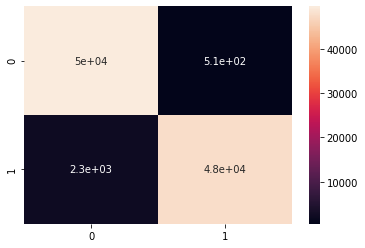

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
cf_matrix=confusion_matrix(y_train, predicted_tr)
sns.heatmap(cf_matrix, annot=True)

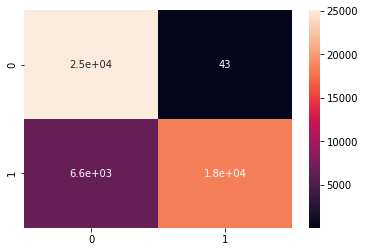

In [ ]:
cf_matrix=confusion_matrix(y_test, predicted_te)
sns.heatmap(cf_matrix, annot=True)

Now trying XGBOOST MODEL:  Random model first folowed by Hyper parameter tuning

In [ ]:
# from xgboost import XGBClassifier

model=xgb.XGBClassifier()
model.fit(df_final_train,y_train)
predicted_tr=model.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)

predicted_te=model.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)
print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)


f1 score for train data: 0.9689788445890969
f1 score for test data: 0.7939674363787157


In [ ]:
# now doing hyperparameter tuning for xgboost
model=xgb.XGBClassifier(max_depth=2,n_estimators=250,subsample=0.5,min_child_weight=2,learning_rate=0.1 )
model.fit(df_final_train,y_train)
predicted_tr=model.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)

predicted_te=model.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)
print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)



f1 score for train data: 0.972213492827817
f1 score for test data: 0.804279982166741


In [ ]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#RandomizedSearchCV
params={'max_depth':[3,4,5,6,7],'n_estimators':[110,112,114,118,121],'subsample':[0.4,0.6,0.7,0.9,0.1],'min_child_weight':[2,3,4,5],'learning_rate':[0.01,0.05,0.07,0.09,0.1]}
model=xgb.XGBClassifier()
tuning=RandomizedSearchCV(model,params,cv=4,scoring='f1',random_state=42,n_jobs=-1)
tuning.fit(df_final_train,y_train)
score_tr=f1_score(y_train,tuning.predict(df_final_train))
score_te=f1_score(y_test,tuning.predict(df_final_test))
print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)
print("the best parameters are:", tuning.best_params_)
 
 



f1 score for train data: 0.9778767331241778
f1 score for test data: 0.7891497702651435
the best parameters are: {'subsample': 0.7, 'n_estimators': 112, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.07}


In [ ]:
model=xgb.XGBClassifier(max_depth=7,n_estimators=112,subsample=0.7,min_child_weight=5,learning_rate=0.07 )
model.fit(df_final_train,y_train)
predicted_tr=model.predict(df_final_train)
score_tr=f1_score(y_train,predicted_tr)

predicted_te=model.predict(df_final_test)
score_te=f1_score(y_test,predicted_te)
print("f1 score for train data:", score_tr)
print("f1 score for test data:",score_te)

f1 score for train data: 0.9778767331241778
f1 score for test data: 0.7891497702651435


**Conclussions:**
First of all, from the given edgelist( having  a direction from source node to destination node. Using networkx we create a graph of all of those data and do some exploratory data analysis using the graph. Similarly, we also create the graph for the test data accordingly. Here we only have a positive class data, for machine learning model, we need both class data atleast if not balanced. Then we try to balance the data by  creating edge from the other nodes( the nodes that are apart from 9.18M edge list data) .

Now we have to split data in such a way that train data contains 80 percent of data from class-1 data and anotehr 80 percent data from class-o data. Similarly, test data contains 20 percent of data from class-1 and another 20 percent from class-0 data . Now we have balanced data. 

Now we add the features accordingly as provided in the notebook. two features svd dot and prefrential attachedment were added by myself. Prefential attachment was quite easy as the instruction provided in the link was very useful. FOr svd dot, 6 svds of source node taking U component of svd function() and 6 svds of source node taking V component of svd function. Svds for both destination were also calculated and their dot product was calculated. 

now we have all features, and its time to apply machine learning model. COmpared to XGBOOST, Random forest did well in my case. Best train accuracy was 96% and best test accuracy(f1 score) was 84% after hyper parameter tuning. 